# Eigenmodes, steady-state problems and efficient time integration

#### Job Marcelis, Ernani Hazbolatow, Koen Verlaan

In [27]:
import numpy as np
from src.eigenmodes import *
from src.leapfrog import *
from src.steadystate import *
from IPython.display import HTML
from matplotlib.animation import PillowWriter


plt.rcParams['animation.embed_limit'] = 100

## 1: Eigenmodes of drums or membranes of different shapes

In this section, we investigate the wave equation of a 2D membrane with fixed boundary conditions along the edge. The 2D wave equation is given by:
\begin{equation}
    \frac{\partial^2 u}{\partial t^2} = c^2\nabla^2 u,
\end{equation}
where $u$ is the amplitude and c is the wave speed.

We look for a solution of the form:
\begin{equation}
    u(x,y,t) = v(x,y)T(t),
\end{equation}
where $v(x,y)$ is the spatial solution and $T(t)$ is the temporal solution.

To discretize $\nabla^2v(x, y) = Kv(x, y)$, we use a 5-point stencil, namely: $\frac{1}{h^2}(v_{i+1, j} + v_{i-1, j} + v_{i, j+1} + v_{i, j-1} -4v_{i,j})$. As an example, we use the following 3 by 3 system:

In [ ]:
draw_system_and_matrix(N=3, h=1, plot_system=True)

Since this is a 3 by 3 system, we have 9 gridpoints, meaning that our resulting matrix is 9 x 9. The entries in the matrix must placed in such a way that it corresponds to the 5-point stencil mentioned earlier:

In [ ]:
draw_system_and_matrix(N=3, h=1, print_latex_matrix=True, plot_system=False)

This matrix looks like:

$$
    \left[\begin{matrix}-4 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\1 & -4 & 1 & 0 & 1 & 0 & 0 & 0 & 0\\0 & 1 & -4 & 0 & 0 & 1 & 0 & 0 & 0\\1 & 0 & 0 & -4 & 1 & 0 & 1 & 0 & 0\\0 & 1 & 0 & 1 & -4 & 1 & 0 & 1 & 0\\0 & 0 & 1 & 0 & 1 & -4 & 0 & 0 & 1\\0 & 0 & 0 & 1 & 0 & 0 & -4 & 1 & 0\\0 & 0 & 0 & 0 & 1 & 0 & 1 & -4 & 1\\0 & 0 & 0 & 0 & 0 & 1 & 0 & 1 & -4\end{matrix}\right]
$$

We have implemented 3 different shapes for the drums/membranes. For each shape the matrix is constructed slightly differently and the equation $Mv = Kv$ is solved using `scipy.sprase.linalg.eigs`. This was done because the matrices are sparse by nature and the calculation would therefore be slow when using `scipy` functions designed for dense matrices. Below we plot the eigenmodes for some of the smallest eigenfrequencies for each shape.

Square:

In [ ]:
L = 1
h = 0.01
N = int(L/h) - 1
M_square = construct_M_square(N, h)
lamda, v = linalg.eigs(M_square, k=4, which='SM')
plot_eigenvectors(lamda, v, grid_shape=(N,N), L=L, plot_title='Eigenmodes of Square Membrane')

Rectangle:

In [ ]:
L = 1
hx = 0.01
hy = 0.02
Nx = int(L/hx) - 1
Ny = int(2*L/hy) - 1
M_rec = construct_M_rec(Nx, Ny, hx, hy)
lamda, v = linalg.eigs(M_rec, k=4, which='SM')
plot_eigenvectors(lamda, v, grid_shape=(Ny, Nx), L=L, shape='rectangle', plot_title='Eigenmodes of Rectangular Membrane')

Circle:

In [ ]:
M_circle = construct_M_circle(N, h, L)
lamda, v = linalg.eigs(M_circle, k=4, which='SM')
plot_eigenvectors(lamda, v, grid_shape=(N,N), L=L, plot_title='Eigenmodes of Circular Membrane')

As mentioned above, we use `eigs()` to compute the eigenvalues and eigenvector since the matrix is sparse. To obtain insight in how much faster `eigs()` is compared to `eig()`, we test the performance on a square grid with different system sizes. Each system size is done 25 times to obtain an average with confidence intervals.

In [ ]:
Ns = np.linspace(10, 30, 15)
num_runs = 25
mean_eig, CI_eig, mean_eigs, CI_eigs = performance_compare(Ns, num_runs, plot=True)

We now investigate what happends when the system size L is varied by plotting the eigenfrequencies for each shape as a function of L.

In [ ]:
Ls = np.linspace(0.25, 2, 15)
h = 0.01

eig_freq_sq = spectrum_vs_L(Ls, h, 'square')
eig_freq_rec = spectrum_vs_L(Ls, h, 'rectangle')
eig_freq_cir = spectrum_vs_L(Ls, h, 'circle')

plot_spectrum_vs_L(Ls, eig_freq_sq, eig_freq_rec, eig_freq_cir)

We also investigate what happens when the number of discretization steps is changed.

In [ ]:
Ns = np.linspace(3, 50, 15)
L = 1.0

freq_vs_N_sq = spectrum_vs_num_steps(Ns, L, 'square')
freq_vs_N_rec = spectrum_vs_num_steps(Ns, L, 'rectangle')
freq_vs_N_cir = spectrum_vs_num_steps(Ns, L, 'circle')

plot_spectrum_vs_num_steps(Ns, freq_vs_N_sq, freq_vs_N_rec, freq_vs_N_cir)

In addition to the solution of the eigenvalue problem, we add the time component. We then have a solution of the form: $u(x,y,t) = v(x,y)T(t)$, where $T(t) = Acos(c\lambda t) + Bsin(c\lambda t)$. To simplify, we choose $c = 1$, $A = 1$, and $B=0$.

In [ ]:
c = 1
L = 1
h = 0.01
N = int(L/h) - 1
total_time = np.linspace(0, 20*np.pi, 100)
M_square = construct_M_square(N, h)
lamda, v = linalg.eigs(M_square, k=8, which='SM')
idx = np.flip(np.argsort(np.real(lamda)))
lamda = lamda[idx]
v = v[:, idx]

In [ ]:
ani = time_dependent_modes(total_time, c, lamda, v, N, mode_number=2)
# ani.save('mode_2_square_membrane.gif', writer=PillowWriter(fps=30))
HTML(ani.to_jshtml())

In [ ]:
ani1 = time_dependent_modes(total_time, c, lamda, v, N, mode_number=4)
# ani1.save('mode_4_square_membrane.gif', writer=PillowWriter(fps=30))
HTML(ani1.to_jshtml())

In [ ]:
ani2 = time_dependent_modes(total_time, c, lamda, v, N, mode_number=6)
# ani2.save('mode_6_square_membrane.gif', writer=PillowWriter(fps=30))
HTML(ani2.to_jshtml())

## 2: Solving Steady State Problems
In this section, we find the steady state of a system by using a direct solver. The domain is defined as a disk of radius $r$ (e.g., $r=2$) centered at the origin. A 2D grid is generated over the interval $[-r, r]$ in both the $x$ and $y$ directions using a specified step size (e.g., step=0.1 or step=0.01). A boolean mask identifies grid points that satisfy $x^2+y^2\leq r^2$, representing the interior of the circle.

We model diffusion in a circular domain by solving the steady state Laplace equation:
$$
\nabla^2 c = 0.
$$
A discrete 2D Laplacian is constructed on a grid covering $[-r, r]$ (with $r=2$) using a 5-point stencil:
$$
\nabla^2 c_{i,j} \approx c_{i+1,j} + c_{i-1,j} + c_{i,j+1} + c_{i,j-1} - 4c_{i,j}.
$$
Dirichlet boundary conditions are enforced via a mask function.
$$
\Phi(x,y)= \begin{cases}1, & x^2+y^2\leq r^2,\\0, & \text{otherwise,}\end{cases}
$$
which modifies the Laplacian as
$$
(\mathbf{D}\mathbf{M}\mathbf{D})\mathbf{c} = \mathbf{0}.
$$
A sink is imposed at $(0.6,1.2)$ by fixing the corresponding entry in $\mathbf{c}$ to 1. The sparse system is solved using $\texttt{scipy.sparse.linalg.spsolve}$, and the resulting steady state concentration is visualized.

First, we create an instance of the diffusive circle with step $\delta x$ = 0.01 and plot the steady state solution. A sink is placed at $(0.6, 1.2)$

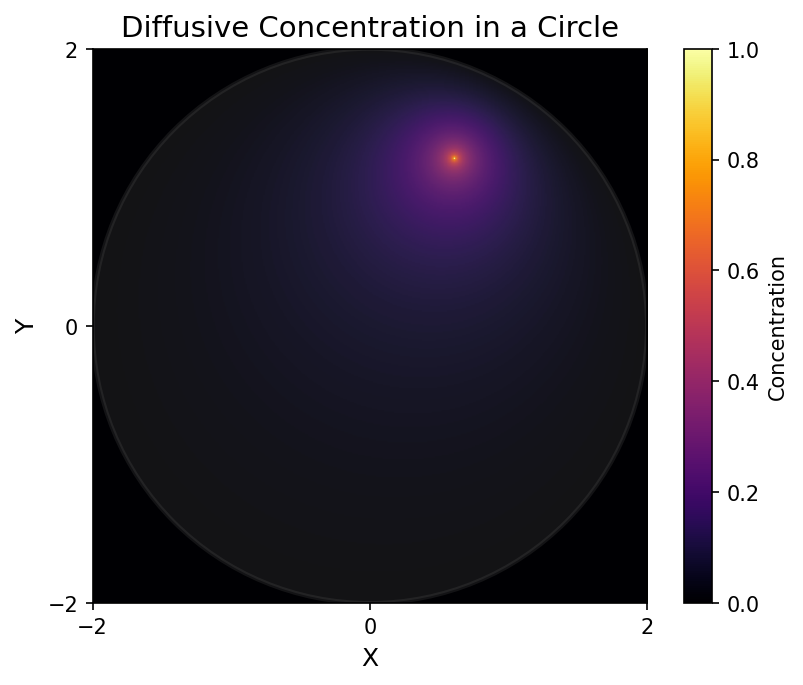

In [32]:
diff_circle_fine = DiffusiveCircle(r=2, step=0.01)
diff_circle_fine.initialize_concentration(sinks=((0.6, 1.2),))
diff_circle_fine.solve_steady_state()
diff_circle_fine.plot_concentration()

Now, we create a diffusive circle with $\delta x = 0.1$. This step size results in poor resolution. However, we will use it to highlight visually the limitation of our methodology. Smooth boundaries are ill-discretionized with the finite difference method. First, we show this for our coarser grid. We zoom in at the boundary as that is where the error will be located.

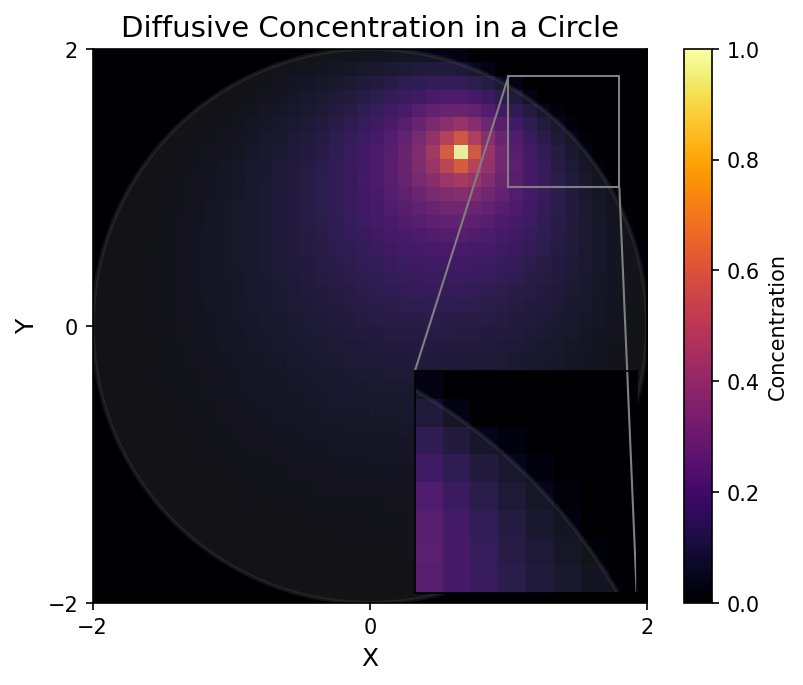

In [34]:
# Solve and plot.
diff_circle_coarse = DiffusiveCircle(r=2, step=0.1)
diff_circle_coarse.initialize_concentration(sinks=((0.6, 1.2),))
diff_circle_coarse.solve_steady_state()
diff_circle_coarse.plot_concentration(zoom=[(1, 1.8), (1, 1.8)])


We contrast this with the earlier diffusive circle with better resolution. The error is visually gone with our current plot setting, but still exists. We can re-introduce this error visually by normalizing the colormap from $0.05$ to $0$ and zooming in by a factor of $10$. 

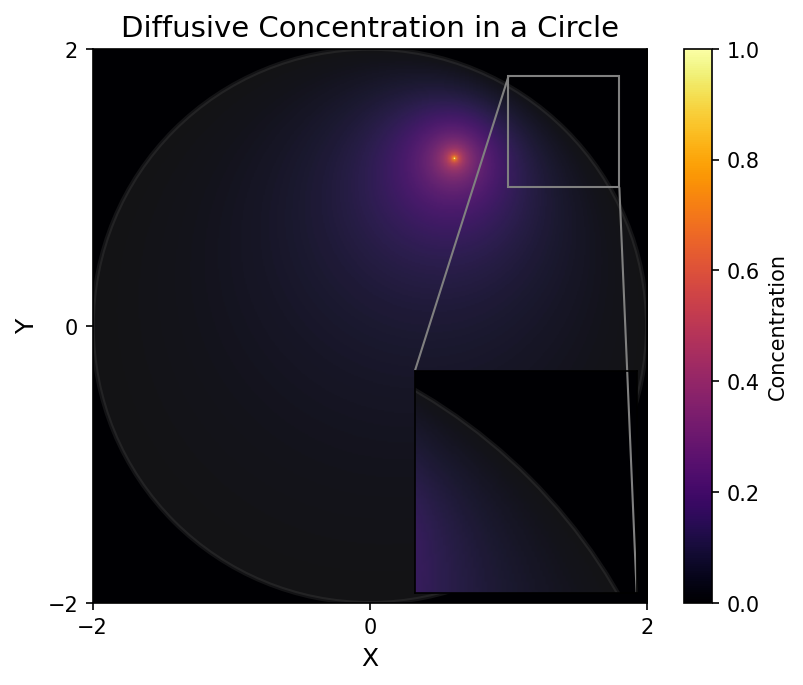

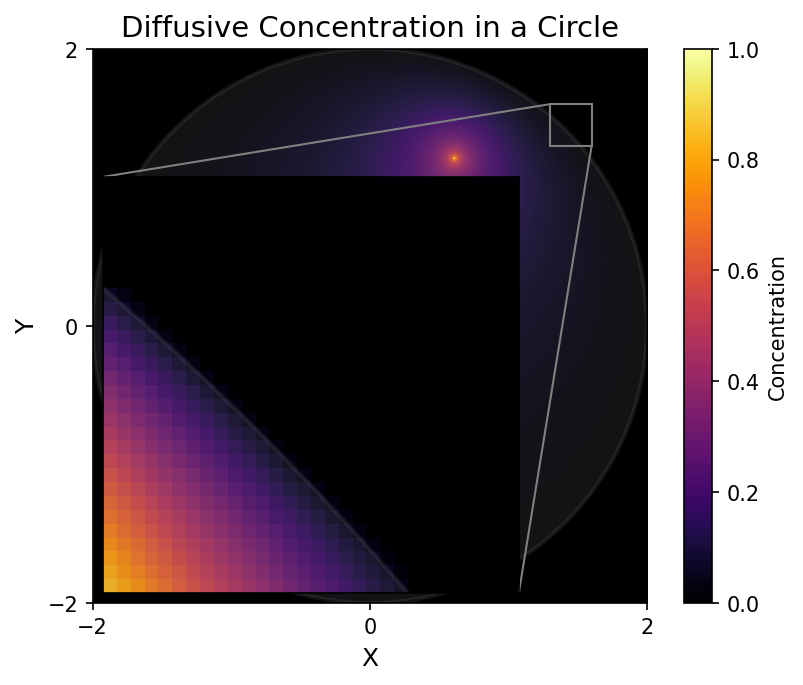

In [35]:
diff_circle_fine.plot_concentration(zoom=[(1, 1.8), (1, 1.8)])
diff_circle_fine.plot_concentration(zoom=[(1.3, 1.6), (1.3, 1.6)], norm = mcolors.Normalize(vmin=0, vmax=0.05), zoom_factor= 10, zoom_loc='lower left')

## 3: Leapfrog method
In this section, we demonstrate the leapfrog method for a one dimensional harmonic oscillator. Also, we compare it's energy conservation over long simulation times to the Range-Kutta 45 integrator. Lastly, we introduce a external sinusoidal driving force to the oscillator and observe its effects for various frequencies. 

To model a one-dimensional harmonic oscillator, we calculate the force following Hookes Law:
\begin{equation}
F(x) = -kx,
\end{equation}
where k is the spring constant and x is the position.

The leapfrog method updates position and velocity at staggered time points:
\begin{equation}
x_{n+1} = x_n + v_{n+1/2} \Delta t
\end{equation}

\begin{equation}
v_{n+3/2} = v_{n+1/2} + \frac{F(x_{n+1})}{m} \Delta t
\end{equation}

For initialization, we compute the half-step velocity:
\begin{equation}
v_{1/2} = v_0 + \frac{1}{2} \frac{F(x_0)}{m} \Delta t = v_0 - \frac{k}{2m} x_0 \Delta t
\end{equation}

We first plot the velocity and position for varying values of k.

In [ ]:
# Set parameters
m = 1
x0 = 1
v0 = 0
dt = 0.01
T = 20

# Solve the harmonic oscillator for different values of k
Ks = [1, 2, 4]
Xs = np.zeros((len(Ks), int(T/dt)+1))
Vs = np.zeros((len(Ks), int(T/dt)+1))

for k in Ks:
    x, v, energy, t = leapfrog_harmonic_oscillator(m, k, x0, v0, dt, T)
    Xs[Ks.index(k)] = x
    Vs[Ks.index(k)] = v

plot_harmonic_oscillator(Ks, Xs, Vs, t)

The leapfrog method supposedly is an symplectic integrator, meaning the energy is conserved over a long period of time. We compare it's energy conservation with the RK45 integrator.

In [ ]:
k = 1
T = 400
compare_energy_conservation(m, k, x0, v0, dt, T)

Lastly, we introduce a sinusoidal driving force of of which we will observe the effects under different circumstances.

In [ ]:
# Different driving amplitudes
driving_amplitudes = [0.5, 2.0]

# Different frequency ratios
frequency_ratios = [0.8, 1.0, 1.2]

# Run the analysis
driven_oscillator_analysis(m, k, x0, v0, dt, 50.0, 
                            driving_amplitudes, frequency_ratios)

Let's animate the driven oscillator at resonance

In [ ]:
natural_freq = np.sqrt(k/m)
resonant_idx = np.argmin(np.abs(np.array(frequency_ratios) - 1.0))
resonant_ratio = frequency_ratios[resonant_idx]    
animation = animate_driven_oscillator(m, k, x0, v0, dt, 50, 
                                   driving_force=(driving_amplitudes[0], resonant_ratio*natural_freq))
HTML(animation.to_jshtml())